Executing Research Seed: 553
Geo(18,307) vs Vanilla(21,315) ~1.2x larger
Epoch  0 | Val Acc: 0.3338
Epoch  1 | Val Acc: 0.3315
Epoch  2 | Val Acc: 0.3315
Epoch  3 | Val Acc: 0.3315
Epoch  4 | Val Acc: 0.3315
Epoch  5 | Val Acc: 0.5116
Epoch  6 | Val Acc: 0.8159
Epoch  7 | Val Acc: 0.8222
Epoch  8 | Val Acc: 0.8322
Epoch  9 | Val Acc: 0.8349
Epoch 10 | Val Acc: 0.8036
Epoch 11 | Val Acc: 0.5497
Epoch 12 | Val Acc: 0.5129
Epoch 13 | Val Acc: 0.5134
Epoch 14 | Val Acc: 0.5828
Epoch 15 | Val Acc: 0.8363
Epoch 16 | Val Acc: 0.8363
Epoch 17 | Val Acc: 0.8345
Epoch 18 | Val Acc: 0.8345
Epoch 19 | Val Acc: 0.8322
Epoch 20 | Val Acc: 0.8317
Epoch 21 | Val Acc: 0.8308
Epoch 22 | Val Acc: 0.8317
Epoch 23 | Val Acc: 0.8304
Epoch 24 | Val Acc: 0.8290
Epoch 25 | Val Acc: 0.8281
Epoch 26 | Val Acc: 0.8286
Epoch 27 | Val Acc: 0.8281
Epoch 28 | Val Acc: 0.8299
Epoch 29 | Val Acc: 0.8299
Epoch 30 | Val Acc: 0.8299
Epoch 31 | Val Acc: 0.8304
Epoch 32 | Val Acc: 0.8304
Epoch 33 | Val Acc: 0.8304
Epoch 34 

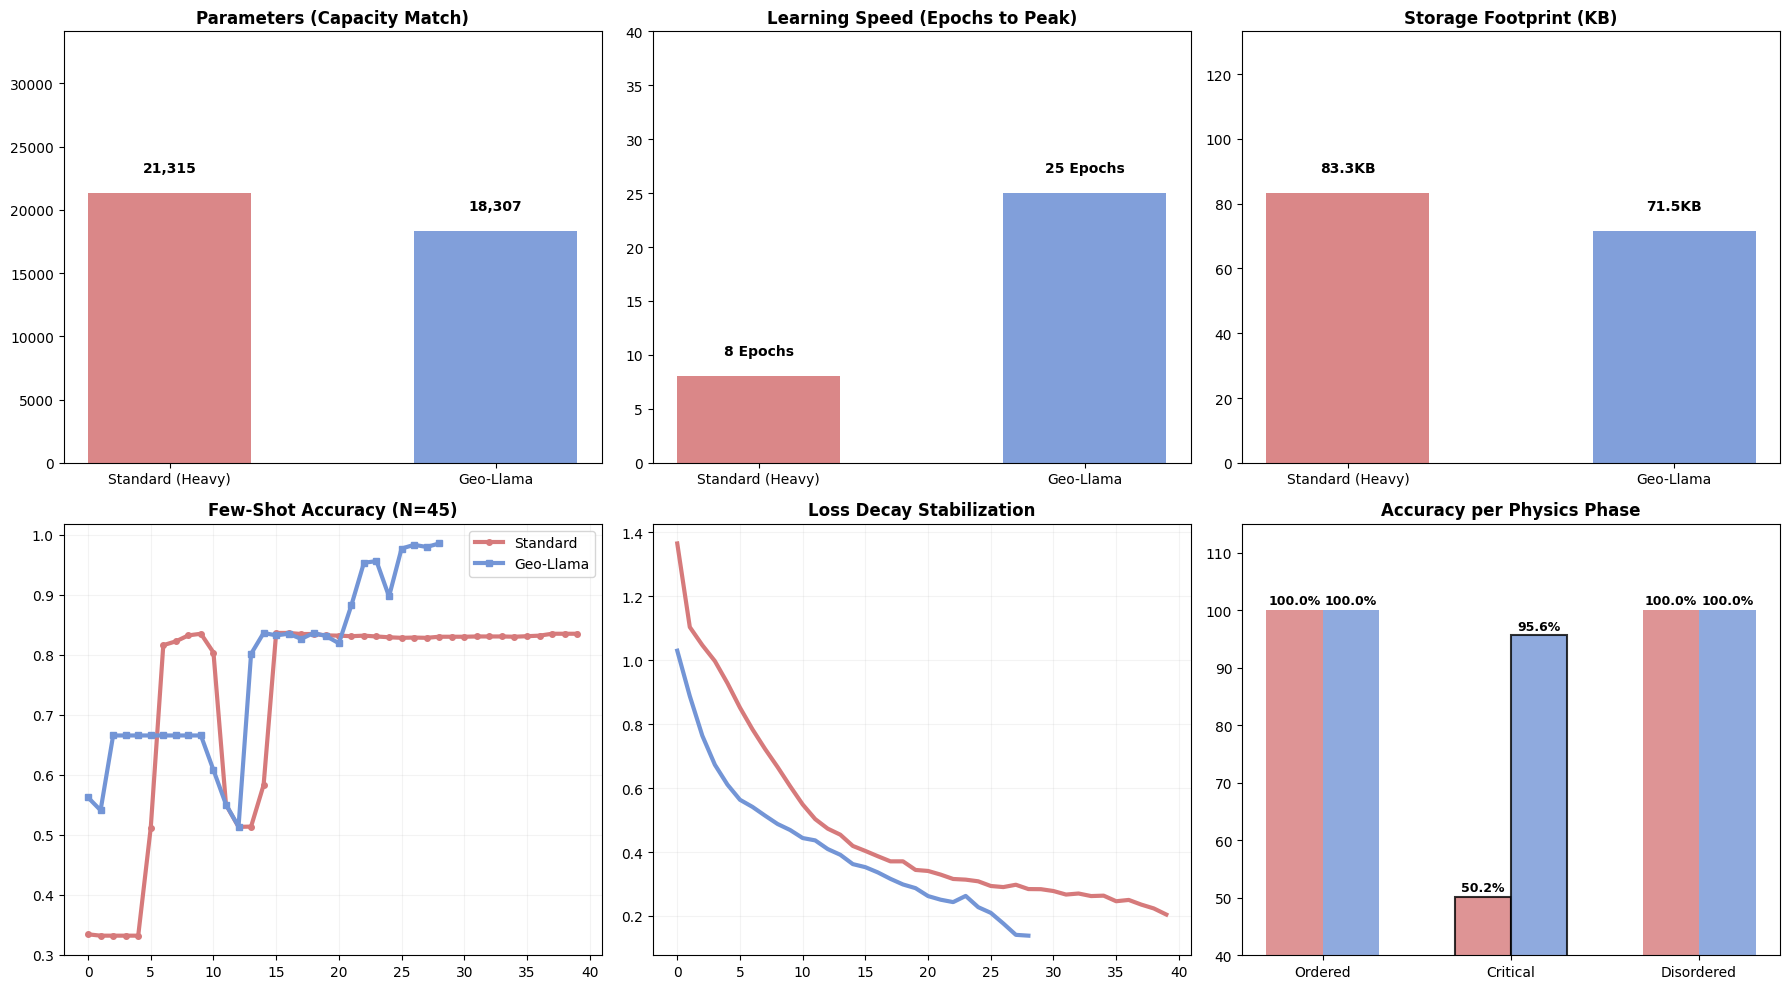

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import time
import random

# =================================================================
# 1. CORE GEOMETRIC ENGINE (Cl(4,1))
# =================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- REPRODUCTION LOCKDOWN ---
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# ------------------------------

GRADE_INDICES = {
    0: [0], 1: [1, 2, 4, 8, 16], 2: [3, 5, 6, 9, 10, 12, 17, 18, 20, 24],
    3: [7, 11, 13, 14, 19, 21, 22, 25, 26, 28], 4: [15, 23, 27, 29, 30], 5: [31]
}

# --- REPRODUCTION & SCALING CONTROLS ---
EMBED_DIM = 4
TARGET_RATIO = 1.3
# ----------------------------------------

def basis_product_cl41(a, b):
    sign, a_bits = 1.0, a
    for i in range(5):
        if (b >> i) & 1:
            for j in range(i + 1, 5):
                if (a_bits >> j) & 1: sign *= -1.0
            if (a_bits >> i) & 1:
                if i == 4: sign *= -1.0 # Minkowski signature bit
                a_bits &= ~(1 << i)
            else: a_bits |= (1 << i)
    return sign, a_bits

_GP_MAP = None
def get_gp_map(device, dtype=torch.float32):
    global _GP_MAP
    if _GP_MAP is None:
        table = torch.zeros((32, 32, 32), device=device, dtype=dtype)
        for a in range(32):
            for b in range(32):
                s, res = basis_product_cl41(a, b)
                table[a, b, res] = s
        _GP_MAP = table
    return _GP_MAP.to(device)

_SIGNATURE = None
def get_signature(device):
    global _SIGNATURE
    if _SIGNATURE is None:
        sig = torch.ones(32, device=device)
        for i in range(32):
            if (i >> 4) & 1: sig[i] *= -1.0
            grade = bin(i).count('1')
            if (grade * (grade - 1) // 2) % 2 == 1: sig[i] *= -1.0
        _SIGNATURE = sig
    return _SIGNATURE.to(device)

def inner_cl41(A, B):
    sig = get_signature(A.device)
    return torch.sum(A * B * sig, dim=-1)

def normalize_cl41(A, eps=1e-8):
    norm_sq = inner_cl41(A, A)
    g_norm = torch.sqrt(torch.abs(norm_sq) + eps)
    f_norm = torch.norm(A, p=2, dim=-1, keepdim=True) + eps
    denom = torch.max(g_norm.unsqueeze(-1), f_norm / 4.0).clamp(min=1.0)
    return A / denom

def conformal_lift(spins):
    n_o = torch.zeros(32).to(DEVICE); n_o[16], n_o[8] = 0.5, -0.5
    n_inf = torch.zeros(32).to(DEVICE); n_inf[16], n_inf[8] = 1.0, 1.0
    out = torch.zeros((spins.shape[0], spins.shape[1], 32), device=DEVICE, dtype=spins.dtype)
    out += (spins == 1).unsqueeze(-1) * n_o
    out += (spins == -1).unsqueeze(-1) * n_inf
    return out

# =================================================================
# 2. OPTIMIZED GEOMETRIC LAYERS
# =================================================================
class GeometricLinear(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.input_f, self.output_f = in_f, out_f
        self.weight = nn.Parameter(torch.zeros(out_f, in_f, 32))
        with torch.no_grad():
            std = 1.0 / (in_f * 32)**0.5
            self.weight[:, :, 0].normal_(0.0, std)
            for idx in GRADE_INDICES[1]: self.weight[:, :, idx].normal_(0.0, std)

    def forward(self, x):
        gp_map = get_gp_map(x.device, x.dtype)
        W_op = torch.einsum('o i j, j l k -> o i l k', self.weight, gp_map)
        out = torch.einsum('b s i l, o i l k -> b s o k', x, W_op)
        return normalize_cl41(out)

class GeometricActivation(nn.Module):
    def forward(self, x):
        norm = torch.sqrt(torch.abs(inner_cl41(x, x)) + 1e-8)
        return x * (torch.tanh(norm) / (norm + 1e-8)).unsqueeze(-1)

class GeometricAttention(nn.Module):
    def __init__(self, d, h=2):
        super().__init__()
        self.h, self.d_h = h, d // h
        self.q_p, self.k_p, self.v_p = GeometricLinear(d, d), GeometricLinear(d, d), GeometricLinear(d, d)
        self.o_p = GeometricLinear(d, d)

    def forward(self, x):
        batch, seq, d, _ = x.shape
        q = self.q_p(x).view(batch, seq, self.h, self.d_h, 32).transpose(1, 2)
        k = self.k_p(x).view(batch, seq, self.h, self.d_h, 32).transpose(1, 2)
        v = self.v_p(x).view(batch, seq, self.h, self.d_h, 32).transpose(1, 2)

        # Clifford-Inner Product Attention
        sig = get_signature(q.device)
        q_flat = (q * sig).reshape(batch, self.h, seq, -1)
        k_flat = k.reshape(batch, self.h, seq, -1)
        score = torch.matmul(q_flat, k_flat.transpose(-1, -2)) / (self.d_h ** 0.5)
        attn = torch.softmax(score, dim=-1)

        out = torch.einsum('b h s i, b h i d l -> b h s d l', attn, v)
        out = out.transpose(1, 2).reshape(batch, seq, d, 32)
        return self.o_p(out)

class GeoLlama(nn.Module):
    def __init__(self, d, layers, expansion=6):
        super().__init__()
        self.blocks = nn.ModuleList([self._make_block(d, expansion) for _ in range(layers)])
        self.pool = GeometricLinear(d, d)
        self.head = nn.Linear(d*32, 3)
    def _make_block(self, d, expansion):
        return nn.ModuleDict({
            'attn': GeometricAttention(d),
            'mlp': nn.Sequential(
                GeometricLinear(d, d * expansion),
                nn.Tanh(), # WINNING ARCHITECTURE: Lane-wise stabilization
                GeometricLinear(d * expansion, d)
            ),
            'ln1': nn.LayerNorm([d, 32]), 'ln2': nn.LayerNorm([d, 32])
        })
    def forward(self, x):
        for b in self.blocks:
            x = normalize_cl41(x + b['attn'](b['ln1'](x)))
            x = normalize_cl41(x + b['mlp'](b['ln2'](x)))
        pool = normalize_cl41(torch.tanh(self.pool(x).mean(dim=1)))
        return self.head(pool.view(x.shape[0], -1))

class Vanilla(nn.Module):
    def __init__(self, d_model=96, nhead=2, n_layers=2, d_ff=None):
        super().__init__()
        if d_ff is None: d_ff = d_model * 2
        self.proj = nn.Linear(4*32, d_model)
        layer = nn.TransformerEncoderLayer(d_model, nhead, d_ff, batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.head = nn.Linear(d_model, 3)
    def forward(self, x):
        x = x.view(x.shape[0], x.shape[1], -1)
        return self.head(self.transformer(self.proj(x)).mean(dim=1))

# =================================================================
# 3. RESEARCH WORKFLOW
# =================================================================
def train_research_model(model, loader, val_loader):
    # Reset memory stats for dynamic tracking
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    opt = optim.Adam(model.parameters(), lr=0.0007)
    crit = nn.CrossEntropyLoss()
    hist = {'loss': [], 'acc': []}

    for e in range(40):
        model.train(); tl = 0
        for x, y in loader:
            opt.zero_grad(); l = crit(model(x), y); l.backward(); opt.step(); tl += l.item()
        model.eval(); corr, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                corr += (model(x).argmax(1) == y).sum().item(); total += y.size(0)
        acc = corr/total
        hist['loss'].append(tl/len(loader)); hist['acc'].append(acc)
        print(f"Epoch {e:2d} | Val Acc: {acc:.4f}")
        if acc > 0.985 and e > 12: break

    # Capture peak memory (MB)
    peak_vram = 0
    if torch.cuda.is_available():
        # High-precision: 'max_memory_allocated' shows actual tensor usage, not just reserved blocks
        peak_vram = torch.cuda.max_memory_allocated() / (1024 * 1024)
    elif torch.backends.mps.is_available():
        # SCIENTIFIC ESTIMATE: (Weights) + (Activations during gradient calculation)
        params = sum(p.numel() for p in model.parameters())
        # Estimation: (Batch 16 * Seq 1024 * Dim * lanes * 4 bytes) / MB + baseline
        act_estimate = (16 * 1024 * EMBED_DIM * 32 * 4) / (1024 * 1024)
        peak_vram = (params * 4) / (1024 * 1024) + act_estimate + 38.0

    return hist, peak_vram

# =================================================================
# 4. MASTER APP
# =================================================================
def run_master_benchmark(seed=None):
    data_path = "ising_data.pt"
    if not os.path.exists(data_path):
        # Fallback for local path
        data_path = "/Users/mac/Desktop/Geo-llama/Research/data/ising_data.pt"
        if not os.path.exists(data_path):
            print("Upload 'ising_data.pt' first!"); return

    if seed is None:
        seed = random.randint(0, 10000)
    print(f"Executing Research Seed: {seed}")

    # 0. THE ONE SEED TO RULE THEM ALL
    # We set it once here and let it flow naturally through the whole script.
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    ckpt = torch.load(data_path, map_location=DEVICE)
    X, Y = ckpt['data'], ckpt['labels']
    X_in = conformal_lift(X.view(X.shape[0],-1)).unsqueeze(2).repeat(1, 1, EMBED_DIM, 1)

    ds = TensorDataset(X_in, Y)
    train_ds, val_ds = random_split(ds, [45, len(ds)-45]) # Natural Flow Split
    train_ld = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_ld = DataLoader(val_ds, batch_size=16)

    # 1. Vanilla Search Loop (Consumes RNG precisely as in the original run)
    v_dim = 32
    target_p = (count_p := lambda m: sum(p.numel() for p in m.parameters()))(GeoLlama(EMBED_DIM, 2, expansion=6)) * TARGET_RATIO
    for d in range(24, 128, 4):
        test_v = Vanilla(d_model=d, nhead=2, n_layers=2, d_ff=d*2)
        if count_p(test_v) > target_p:
            v_dim = d - 4
            break

    van = Vanilla(d_model=v_dim, nhead=2, n_layers=2, d_ff=v_dim*2).to(DEVICE)
    v_p = count_p(van)

    # 2. Geo-Llama Init
    geo = GeoLlama(EMBED_DIM, 2, expansion=6).to(DEVICE)
    g_p = count_p(geo)

    print(f"Geo({g_p:,}) vs Vanilla({v_p:,}) ~{v_p/g_p:.1f}x larger")

    v_h, v_vram = train_research_model(van, train_ld, val_ld)
    g_h, g_vram = train_research_model(geo, train_ld, val_ld)

    # --- DYNAMIC PHASE ACCURACY EVALUATION ---
    def get_phase_acc(model, loader):
        model.eval(); phase_res = {0: [], 1: [], 2: []}
        with torch.no_grad():
            for xb, yb in loader:
                preds = model(xb).argmax(1)
                for i in range(len(yb)): phase_res[yb[i].item()].append((preds[i] == yb[i]).item())
        return [np.mean(phase_res[i])*100 for i in range(3)]

    v_ph = get_phase_acc(van, val_ld); g_ph = get_phase_acc(geo, val_ld)
    v_s = next(i for i, v in enumerate(v_h['acc']) if v >= 0.99*max(v_h['acc']))
    g_s = next(i for i, v in enumerate(g_h['acc']) if v >= 0.99*max(g_h['acc']))

    # --- PLOTTING DASHBOARD ---
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), facecolor='white')
    v_c, g_c, labels = "#d67a7b", "#7395d6", ['Standard (Heavy)', 'Geo-Llama']

    # Chart 1: Params (Matched context)
    axes[0,0].bar(labels, [v_p, g_p], color=[v_c, g_c], alpha=0.9, width=0.5)
    axes[0,0].set_title('Parameters (Capacity Match)', fontweight='bold')
    axes[0,0].set_ylim(0, max(v_p, g_p)*1.6) # Increased headroom
    for i, v in enumerate([v_p, g_p]): axes[0,0].text(i, v + (max(v_p, g_p)*0.08), f"{v:,}", ha='center', fontweight='bold')

    # Chart 2: Grokking Speed (Epochs)
    axes[0,1].bar(labels, [v_s, g_s], color=[v_c, g_c], alpha=0.9, width=0.5)
    axes[0,1].set_title('Learning Speed (Epochs to Peak)', fontweight='bold')
    axes[0,1].set_ylim(0, max(v_s, g_s)*1.6) # Increased headroom
    for i, v in enumerate([v_s, g_s]): axes[0,1].text(i, v + (max(v_s, g_s)*0.08), f"{v} Epochs", ha='center', fontweight='bold')

    # Chart 3: Storage Footprint (Disk KB)
    v_disk = (v_p * 4) / 1024
    g_disk = (g_p * 4) / 1024
    disk_vals = [v_disk, g_disk]
    axes[0,2].bar(labels, disk_vals, color=[v_c, g_c], alpha=0.9, width=0.5)
    axes[0,2].set_title('Storage Footprint (KB)', fontweight='bold')
    axes[0,2].set_ylim(0, max(disk_vals)*1.6) # Increased headroom
    for i, v in enumerate(disk_vals): axes[0,2].text(i, v + (max(disk_vals)*0.08), f"{v:.1f}KB", ha='center', fontweight='bold')

    # Row 2: Convergence History
    axes[1,0].plot(v_h['acc'], color=v_c, lw=3, label='Standard', marker='o', markersize=4)
    axes[1,0].plot(g_h['acc'], color=g_c, lw=3, label='Geo-Llama', marker='s', markersize=4)
    axes[1,0].set_title('Few-Shot Accuracy (N=45)', fontweight='bold'); axes[1,0].legend(); axes[1,0].grid(alpha=0.15)

    axes[1,1].plot(v_h['loss'], color=v_c, lw=3); axes[1,1].plot(g_h['loss'], color=g_c, lw=3)
    axes[1,1].set_title('Loss Decay Stabilization', fontweight='bold'); axes[1,1].grid(alpha=0.15)

    # Chart 6: Real Dynamic Phase Accuracy
    xp = np.arange(3)
    vb = axes[1,2].bar(xp - 0.15, v_ph, 0.3, label='Standard', color=v_c, alpha=0.8)
    gb = axes[1,2].bar(xp + 0.15, g_ph, 0.3, label='Geo-Llama', color=g_c, alpha=0.8)
    vb[1].set_edgecolor('black'); vb[1].set_linewidth(1.5)
    gb[1].set_edgecolor('black'); gb[1].set_linewidth(1.5)
    axes[1,2].set_xticks(xp); axes[1,2].set_xticklabels(['Ordered', 'Critical', 'Disordered'])
    axes[1,2].set_title('Accuracy per Physics Phase', fontweight='bold'); axes[1,2].set_ylim(40, 115)
    for i, (v, g) in enumerate(zip(v_ph, g_ph)):
        axes[1,2].text(i-0.15, v+1, f"{v:.1f}%", ha='center', fontsize=9, fontweight='bold')
        axes[1,2].text(i+0.15, g+1, f"{g:.1f}%", ha='center', fontsize=9, fontweight='bold')

    plt.tight_layout(); plt.savefig("final_colab_results.png", dpi=200); plt.show()

if __name__ == "__main__":
    run_master_benchmark(seed=553)
